## Part A Question 2


In [1]:
import time
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import shap
shap.initjs()


import IPython.display as ipd

from scipy.io import wavfile as wav

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix


import tensorflow.keras as keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import *
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping,ModelCheckpoint,LearningRateScheduler
from sklearn import datasets
from sklearn.model_selection import KFold

c:\Users\JoeTe\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
SEED = 42
import os
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

import random 
random.seed(SEED)

import numpy as np
np.random.seed(SEED)

import tensorflow as tf
tf.random.set_seed(SEED)

In [3]:
df = pd.read_csv('./full.csv') 
df.head()

,filename,tempo,total_beats,average_beats,chroma_stft_mean,chroma_stft_var,chroma_cq_mean,chroma_cq_var,chroma_cens_mean,chroma_cens_var,...,mfcc15_mean,mfcc15_var,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var
0,app_3001_4001_phnd_neg_0000.wav,184.570312,623,69.222222,0.515281,0.093347,0.443441,0.082742,0.249143,0.021261,...,-10.669799,63.340282,1.811605,58.117188,-3.286546,54.268448,-2.719069,59.548176,-4.559987,70.774803
1,app_3001_4001_phnd_neg_0001.wav,151.999081,521,74.428571,0.487201,0.094461,0.542182,0.073359,0.274423,0.008025,...,-5.666375,90.256195,1.573594,105.070496,-0.742024,82.417496,-1.961745,119.312355,1.513660,101.014572
2,app_3001_4001_phnd_neg_0002.wav,112.347147,1614,146.727273,0.444244,0.099268,0.442014,0.083224,0.264430,0.013410,...,-5.502390,73.079750,0.202623,72.040550,-4.021009,73.844353,-5.916223,103.834824,-2.939086,113.598824
3,app_3001_4001_phnd_neg_0003.wav,107.666016,2060,158.461538,0.454156,0.100834,0.424370,0.084435,0.257672,0.016938,...,-8.812989,93.791893,-0.429413,60.002579,-4.013513,82.544540,-5.858006,84.402092,0.686969,90.126389
4,app_3001_4001_phnd_neg_0004.wav,75.999540,66,33.000000,0.478780,0.100000,0.414859,0.089313,0.252143,0.019757,...,-6.584204,64.973305,0.744403,68.908516,-6.354805,66.414391,-6.555534,47.852840,-4.809713,73.033966


In [4]:
df['label'] = df['filename'].str.split('_').str[-2]
df['label'].value_counts()

pos    92826
neg    89428
Name: label, dtype: int64

In [5]:

columns_to_drop = ['label','filename']

def split_dataset(df, columns_to_drop, test_size, random_state):
  label_encoder = preprocessing.LabelEncoder()

  df['label'] = label_encoder.fit_transform(df['label'])

  df_train, df_test = train_test_split(df, test_size=test_size, random_state=random_state)

  df_train2 = df_train.drop(columns_to_drop,axis=1)
  y_train2 = df_train['label'].to_numpy()

  df_test2 = df_test.drop(columns_to_drop,axis=1)
  y_test2 = df_test['label'].to_numpy() 

  return df_train2, y_train2, df_test2, y_test2

def preprocess_dataset(df_train, df_test):

  standard_scaler = preprocessing.StandardScaler()
  df_train_scaled = standard_scaler.fit_transform(df_train)

  df_test_scaled = standard_scaler.transform(df_test)

  return df_train_scaled, df_test_scaled

X_train, y_train, X_test, y_test = split_dataset(df, columns_to_drop, test_size=0.3, random_state=0) # positive labels being encoded as 1

X_train_scaled, X_test_scaled = preprocess_dataset(X_train, X_test)

In [6]:
num_neurons = 128
learning_rate = 0.001
batch_size = 256
no_epochs = 100

**Timing callback for every epoch**

In [7]:
# TimingCallBack class for Q2b

class TimingCallback(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

**Callback for early stopping**

In [8]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)

**Number of folds and batch sizes**

In [9]:
no_folds = 5
batch_size_list = [128, 256, 512, 1024]
cv = KFold(n_splits=no_folds, shuffle=True, random_state=0)

In [10]:
Q2_X, Q2_Y = X_train_scaled, y_train

In [11]:
model_acc = {}
model_train_acc = {}
model_loss = {}
Q2_history = {}
time_taken_dict = {}
batch_idx = 0

model_list = ["model_128", "model_256", "model_512", "model_1024"]
model_fold = ["_0", "_1", "_2", "_3" ,"_4"]

for models in model_list:
    fold = 0
    train_acc = []
    val_acc = []
    val_loss = []
    time_taken_list = []
    for train_idx, test_idx in cv.split(Q2_X, Q2_Y):
        cb = TimingCallback()
        Q2_X_train, Q2_y_train  = Q2_X[train_idx], Q2_Y[train_idx]
        Q2_X_test, Q2_y_test = Q2_X[test_idx], Q2_Y[test_idx]
    
        
        Q2_model = Sequential([Dense(num_neurons, activation='relu'),
                        Dropout(0.2), Dense(num_neurons, activation ='relu'),
                        Dropout(0.2), Dense(num_neurons, activation='relu'),
                        Dropout(0.2), Dense(1, activation='sigmoid')])
        
        Q2_model.compile(optimizer='adam', 
                    loss='binary_crossentropy',
                    metrics=['accuracy'])
        
        Q2_history[models + model_fold[fold]] = Q2_model.fit(Q2_X_train, Q2_y_train,
                        batch_size = batch_size_list[batch_idx],
                        epochs=no_epochs,
                        verbose=1,
                        use_multiprocessing=True,
                        validation_data=(Q2_X_test, Q2_y_test), callbacks=[callback, cb])
        
        #Time taken of final epoch for each fold 
        time_taken_list.append(cb.times[-1])
        #print("Time Taken for final epoch " + models + model_fold[fold] + " : {}".format(cb.times[-1]))

        #Validation Accuracy of final epoch of each fold
        val_acc.append(Q2_history[models + model_fold[fold]].history['val_accuracy'][-1])

        #Training Accuracy of final epoch of each fold
        train_acc.append(Q2_history[models + model_fold[fold]].history['accuracy'][-1])
        
        #Val loss of final epoch of each fold
        val_loss.append(Q2_history[models + model_fold[fold]].history['val_loss'][-1])

        #print(models +' fold %d test accuracy %g'%(fold, val_acc[fold]))
        fold += 1
    
    batch_idx +=1
    model_acc[models] = val_acc
    model_train_acc[models] = train_acc
    model_loss[models] = val_loss
    time_taken_dict[models]= time_taken_list
    #print(models + '* mean accuracy = %g *'% np.mean(val_acc))

Epoch 1/100
798/798 [==============================] - 5s 4ms/step - loss: 0.6900 - accuracy: 0.5360 - val_loss: 0.6828 - val_accuracy: 0.5535
Epoch 2/100
798/798 [==============================] - 3s 4ms/step - loss: 0.6835 - accuracy: 0.5507 - val_loss: 0.6816 - val_accuracy: 0.5597
Epoch 3/100
798/798 [==============================] - 3s 4ms/step - loss: 0.6807 - accuracy: 0.5580 - val_loss: 0.6785 - val_accuracy: 0.5627
Epoch 4/100
798/798 [==============================] - 3s 4ms/step - loss: 0.6778 - accuracy: 0.5668 - val_loss: 0.6767 - val_accuracy: 0.5673
Epoch 5/100
798/798 [==============================] - 3s 4ms/step - loss: 0.6751 - accuracy: 0.5718 - val_loss: 0.6741 - val_accuracy: 0.5713
Epoch 6/100
798/798 [==============================] - 3s 3ms/step - loss: 0.6713 - accuracy: 0.5779 - val_loss: 0.6710 - val_accuracy: 0.5812
Epoch 7/100
798/798 [==============================] - 4s 5ms/step - loss: 0.6673 - accuracy: 0.5833 - val_loss: 0.6686 - val_accuracy: 0.5801

## Question 2A

#### Scatter plot of Mean Cross-validation accuracies against different batch_sizes

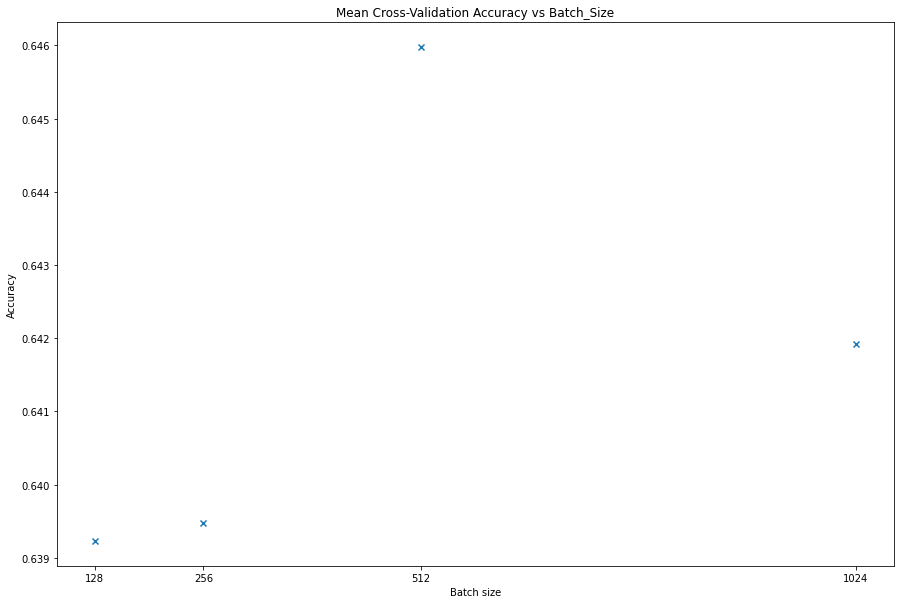

In [12]:
mean_val_acc = []
for key, value in model_acc.items():
    mean_val_acc.append(np.mean(value))

mean_val_loss = []
for key, value in model_loss.items():
    mean_val_loss.append(np.mean(value))

plt_1 = plt.figure(figsize=(15, 10))
plt.scatter(batch_size_list, mean_val_acc, marker = 'x')
plt.title('Mean Cross-Validation Accuracy vs Batch_Size')
plt.ylabel('Accuracy')
plt.xlabel('Batch size')
plt.xticks(batch_size_list)
plt.show()

## Question 2B

#### Scatter plot of mean time taken of final epoch against batch size

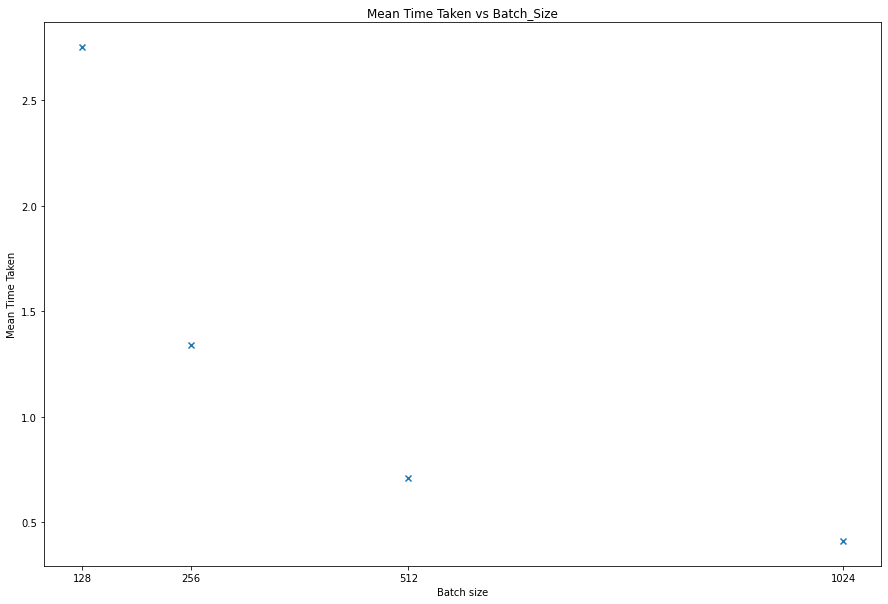

In [13]:
mean_time_taken = []
for key, value in time_taken_dict.items():
    mean_time_taken.append(np.mean(value))

plt_1 = plt.figure(figsize=(15, 10))
plt.scatter(batch_size_list, mean_time_taken, marker = 'x')
plt.title('Mean Time Taken vs Batch_Size')
plt.ylabel('Mean Time Taken')
plt.xlabel('Batch size')
plt.xticks(batch_size_list)
plt.show()

#### Table of time taken to train the last epoch

In [14]:
table_df = pd.DataFrame.from_dict(model_acc,orient='index', columns=["fold_0", "fold_1", "fold_2", "fold_3", "fold_4"])
table_dict = {"Mean Val Acc": mean_val_acc,
              "Mean Val Loss": mean_val_loss,
              "Mean Time Taken": mean_time_taken,
              "Batch Model": model_list,
              "Batch Size": batch_size_list}
data_df = pd.DataFrame.from_dict(table_dict)     
table_df.reset_index(drop=True, inplace=True)
data_df.reset_index(drop=True, inplace=True)        

table_df = pd.concat([table_df, data_df], axis=1)
table_df.set_index('Batch Size', inplace = True)
table_df

,fold_0,fold_1,fold_2,fold_3,fold_4,Mean Val Acc,Mean Val Loss,Mean Time Taken,Batch Model
Batch Size,,,,,,,,,
128,0.632819,0.636816,0.632608,0.647031,0.646874,0.639230,0.625047,2.753952,model_128
256,0.641010,0.640147,0.650598,0.641427,0.624221,0.639480,0.624790,1.340800,model_256
512,0.647946,0.650376,0.635273,0.655575,0.640721,0.645978,0.620062,0.712830,model_512
1024,0.629213,0.650886,0.644248,0.642485,0.642759,0.641918,0.623079,0.411604,model_1024


In [15]:
optimal_batch_size = int(table_df['Mean Val Acc'].idxmax())
print("Optimal batch size: ", optimal_batch_size)

Optimal batch size:  512


## Question 2C
#### Select the optimal batch size and state a reason for your selection

**The optimal batch size is: 512**

**The optimal batch size is selected based on the highest mean validation accuracy that is evaluated through the K-fold cross validation.**

**Even though, we can see a decrease in mean time taken when the batch size increases, we should generally focus on the mean validation accuracy unless training time is defined as a significant measure when we are evaluating a model's performance**

**Overall, the model's performance that is evaluated through the K-fold cross validation generally results in a less-biased estimate of the model performance as compared to a simple train-test split method.**

## Question 2D

#### What happens when batch size increases, and why does it happen?

**As the batch size increases, the training time taken for the final epoch decreases. Holding the number of epochs constant, the total number of gradient descent steps decreases when batch size increases. With bigger batch size, it is equivalent to taking "bigger steps" which would speed up computation time.** 

**However, higher batch size may lead to poorer accuracies as large batch methods tend to converge to sharp minimizers of training and testing functions-and that sharp minima lead to poorer generalization.**


## Question 2E

#### Line Plot of Accuracy vs Epochs for optimal batch size with different folds

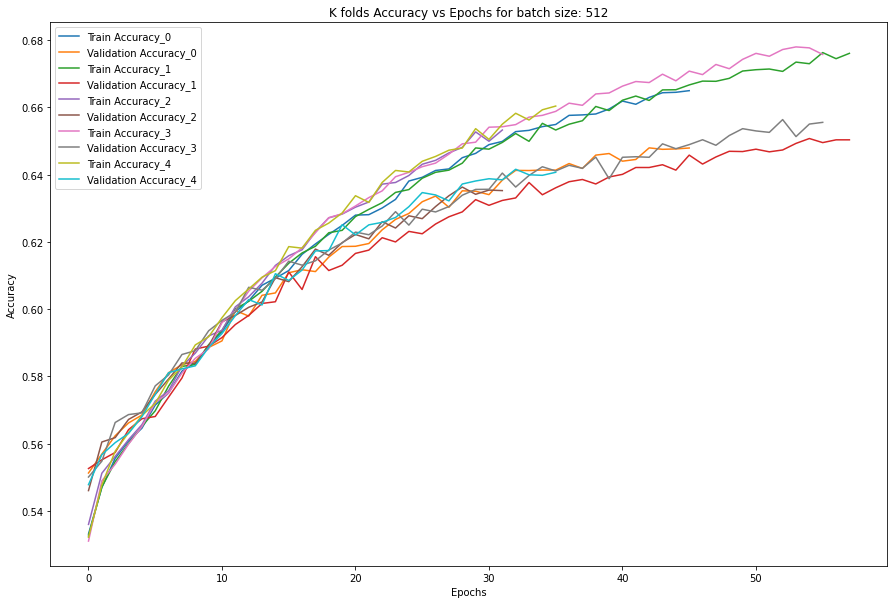

In [16]:
plt_1 = plt.figure(figsize=(15, 10))
optimal_batch_model = str(table_df.loc[optimal_batch_size, "Batch Model"])
fold = 0

Q2_legend_list = []

while(fold<no_folds):
    plt.plot(Q2_history[optimal_batch_model + model_fold[fold]].history["accuracy"])
    Q2_legend_list.append("Train Accuracy" + model_fold[fold])
    plt.plot(Q2_history[optimal_batch_model + model_fold[fold]].history["val_accuracy"])
    Q2_legend_list.append("Validation Accuracy" + model_fold[fold])
    fold+=1

plt.legend(Q2_legend_list)
plt.title('K folds Accuracy vs Epochs for batch size: ' + str(optimal_batch_size))
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.show()

In [17]:
Q2E_model = Sequential([Dense(num_neurons, activation='relu'),
                Dropout(0.2), Dense(num_neurons, activation ='relu'),
                Dropout(0.2), Dense(num_neurons, activation='relu'),
                Dropout(0.2), Dense(1, activation='sigmoid')])

Q2E_model.compile(optimizer='adam', 
            loss='binary_crossentropy',
            metrics=['accuracy'])

Q2E_history = {}
Q2E_history["Q2E_model"] = Q2E_model.fit(X_train_scaled, y_train,
                batch_size = optimal_batch_size,
                epochs=no_epochs,
                verbose=1,
                use_multiprocessing=True,
                validation_data=(X_test_scaled, y_test), callbacks=[callback, cb])

Epoch 1/100
250/250 [==============================] - 3s 7ms/step - loss: 0.6913 - accuracy: 0.5334 - val_loss: 0.6852 - val_accuracy: 0.5511
Epoch 2/100
250/250 [==============================] - 1s 6ms/step - loss: 0.6845 - accuracy: 0.5499 - val_loss: 0.6819 - val_accuracy: 0.5553
Epoch 3/100
250/250 [==============================] - 1s 6ms/step - loss: 0.6809 - accuracy: 0.5573 - val_loss: 0.6815 - val_accuracy: 0.5556
Epoch 4/100
250/250 [==============================] - 1s 6ms/step - loss: 0.6788 - accuracy: 0.5616 - val_loss: 0.6778 - val_accuracy: 0.5669
Epoch 5/100
250/250 [==============================] - 1s 6ms/step - loss: 0.6759 - accuracy: 0.5687 - val_loss: 0.6751 - val_accuracy: 0.5712
Epoch 6/100
250/250 [==============================] - 1s 5ms/step - loss: 0.6739 - accuracy: 0.5720 - val_loss: 0.6736 - val_accuracy: 0.5762
Epoch 7/100
250/250 [==============================] - 1s 5ms/step - loss: 0.6706 - accuracy: 0.5785 - val_loss: 0.6695 - val_accuracy: 0.5821

#### Line Plot of Accuracy vs Epochs for optimal batch size 

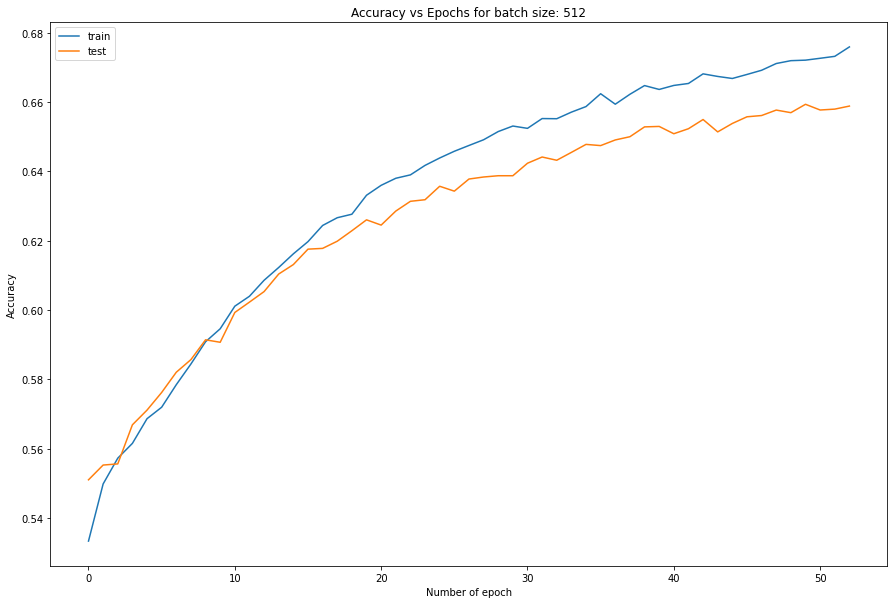

In [18]:
plt_1 = plt.figure(figsize=(15, 10))
plt.plot(Q2E_history['Q2E_model'].history['accuracy'])
plt.plot(Q2E_history['Q2E_model'].history['val_accuracy'])
plt.title('Accuracy vs Epochs for batch size: ' + str(optimal_batch_size))
plt.ylabel('Accuracy')
plt.xlabel('Number of epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()